# Speech Processing Lab Assignment - 4
## Frame-wise Analysis of Speech Signal: Time-Domain Features for Voiced and Unvoiced Speech
Name: Sanjushree Rajan<br>
Reg. no.: BL.EN.U4AIE23130<br>

**Objective:** Perform frame-wise analysis of a speech signal and study the behaviour of time-domain features for voiced and unvoiced speech.

## Setup & Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from scipy.signal.windows import hamming
import warnings
warnings.filterwarnings('ignore')

# Install if needed:
# !pip install librosa soundfile

plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['axes.grid'] = True
print('Imports successful.')

Imports successful.


## Load Speech Signal

You can use your own `.wav` file or download from LJ Speech Dataset. Place the file in the same directory and update the path below.

In [5]:
# -------------------------------------------------------
# CONFIG — update this path to point to your .wav file
AUDIO_FILE = 'speech.wav'
TARGET_SR  = 16000          # 16 kHz
DURATION   = 20             # first 20 seconds
# -------------------------------------------------------

# Load (resample to 16 kHz if needed)
signal, sr = librosa.load(AUDIO_FILE, sr=TARGET_SR, duration=DURATION, mono=True)
print(f'Sample rate : {sr} Hz')
print(f'Duration    : {len(signal)/sr:.2f} s')
print(f'Total samples: {len(signal)}')

Sample rate : 16000 Hz
Duration    : 7.58 s
Total samples: 121344


---
## Task 1 — Short-Time Processing of Speech
### 1a) Waveform Visualization (first 20 seconds)

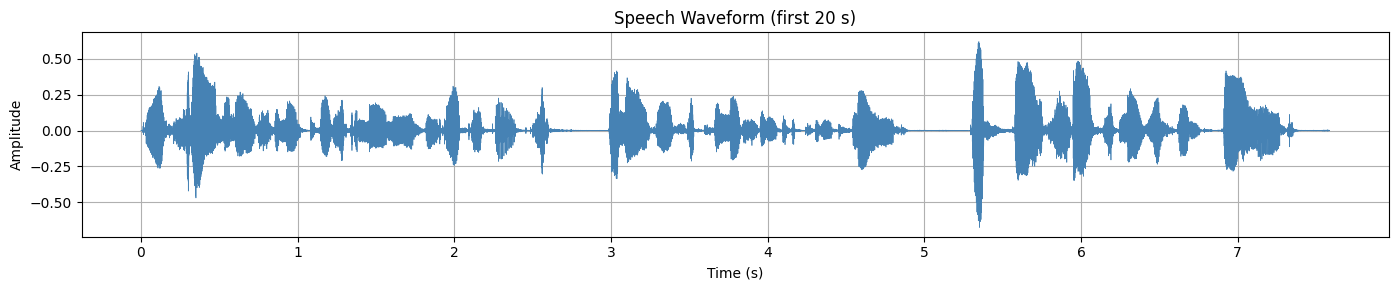

In [6]:
time_axis = np.arange(len(signal)) / sr

plt.figure(figsize=(14, 3))
plt.plot(time_axis, signal, linewidth=0.5, color='steelblue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Speech Waveform (first 20 s)')
plt.tight_layout()
plt.show()

### 1b) Framing Parameters

In [7]:
frame_length_ms = 25   # ms
frame_shift_ms  = 10   # ms

frame_length = int(frame_length_ms * sr / 1000)  # samples
frame_shift  = int(frame_shift_ms  * sr / 1000)  # samples

num_frames = 1 + (len(signal) - frame_length) // frame_shift

print(f'Frame length : {frame_length} samples ({frame_length_ms} ms)')
print(f'Frame shift  : {frame_shift}  samples ({frame_shift_ms} ms)')
print(f'Total frames : {num_frames}')

Frame length : 400 samples (25 ms)
Frame shift  : 160  samples (10 ms)
Total frames : 756


### 1c) Frame Segmentation

In [8]:
def segment_frames(signal, frame_length, frame_shift):
    """Return 2D array of shape (num_frames, frame_length)."""
    num_frames = 1 + (len(signal) - frame_length) // frame_shift
    frames = np.zeros((num_frames, frame_length))
    for i in range(num_frames):
        start = i * frame_shift
        frames[i] = signal[start:start + frame_length]
    return frames

frames_raw = segment_frames(signal, frame_length, frame_shift)
print(f'Frames array shape: {frames_raw.shape}')

Frames array shape: (756, 400)


### 1d & 1e) Window Functions + Feature Extraction Functions

In [9]:
# --- Window functions ---
hamming_win   = np.hamming(frame_length)
rect_win      = np.ones(frame_length)

# Apply windows to all frames
frames_hamming = frames_raw * hamming_win
frames_rect    = frames_raw * rect_win

# --- Feature functions ---

def compute_STE(frames):
    """Short-Time Energy: sum of squared samples per frame."""
    return np.sum(frames ** 2, axis=1)

def compute_STM(frames):
    """Short-Time Magnitude: sum of absolute values per frame."""
    return np.sum(np.abs(frames), axis=1)

def compute_ZCR(frames):
    """Zero-Crossing Rate: number of sign changes per frame."""
    signs = np.sign(frames)
    zcr = np.sum(np.abs(np.diff(signs)), axis=1) / (2 * frames.shape[1])
    return zcr

def compute_autocorrelation(frames):
    """Normalised autocorrelation at lag 1 … frame_length-1. Returns R[1] (lag-1 value) per frame."""
    # For a compact scalar feature we use the peak value of normalised ACF
    acf_peak = []
    for frame in frames:
        acf = np.correlate(frame, frame, mode='full')
        acf = acf[len(frame)-1:]  # keep non-negative lags
        if acf[0] != 0:
            acf = acf / acf[0]   # normalise
        # Peak after lag 0 (excluding zero lag)
        acf_peak.append(np.max(acf[1:]) if len(acf) > 1 else 0)
    return np.array(acf_peak)

def compute_AMDF(frames):
    """Average Magnitude Difference Function — minimum value per frame (for feature plot)."""
    amdf_min = []
    N = frames.shape[1]
    for frame in frames:
        amdf = np.array([np.mean(np.abs(frame[k:] - frame[:N-k])) for k in range(1, N//2)])
        amdf_min.append(np.min(amdf) if len(amdf) > 0 else 0)
    return np.array(amdf_min)

def compute_AMSDF(frames):
    """Average Magnitude Squared Difference Function — minimum value per frame."""
    amsdf_min = []
    N = frames.shape[1]
    for frame in frames:
        amsdf = np.array([np.mean((frame[k:] - frame[:N-k])**2) for k in range(1, N//2)])
        amsdf_min.append(np.min(amsdf) if len(amsdf) > 0 else 0)
    return np.array(amsdf_min)

print('Feature functions defined.')

Feature functions defined.


In [10]:
print('Computing features for Hamming window...')
ste_h   = compute_STE(frames_hamming)
stm_h   = compute_STM(frames_hamming)
zcr_h   = compute_ZCR(frames_hamming)
acf_h   = compute_autocorrelation(frames_hamming)
amdf_h  = compute_AMDF(frames_hamming)
amsdf_h = compute_AMSDF(frames_hamming)

print('Computing features for Rectangular window...')
ste_r   = compute_STE(frames_rect)
stm_r   = compute_STM(frames_rect)
zcr_r   = compute_ZCR(frames_rect)
acf_r   = compute_autocorrelation(frames_rect)
amdf_r  = compute_AMDF(frames_rect)
amsdf_r = compute_AMSDF(frames_rect)

print('Done.')

Computing features for Hamming window...
Computing features for Rectangular window...
Done.


### 1f) Plot Frame-wise Features (Hamming vs Rectangular)

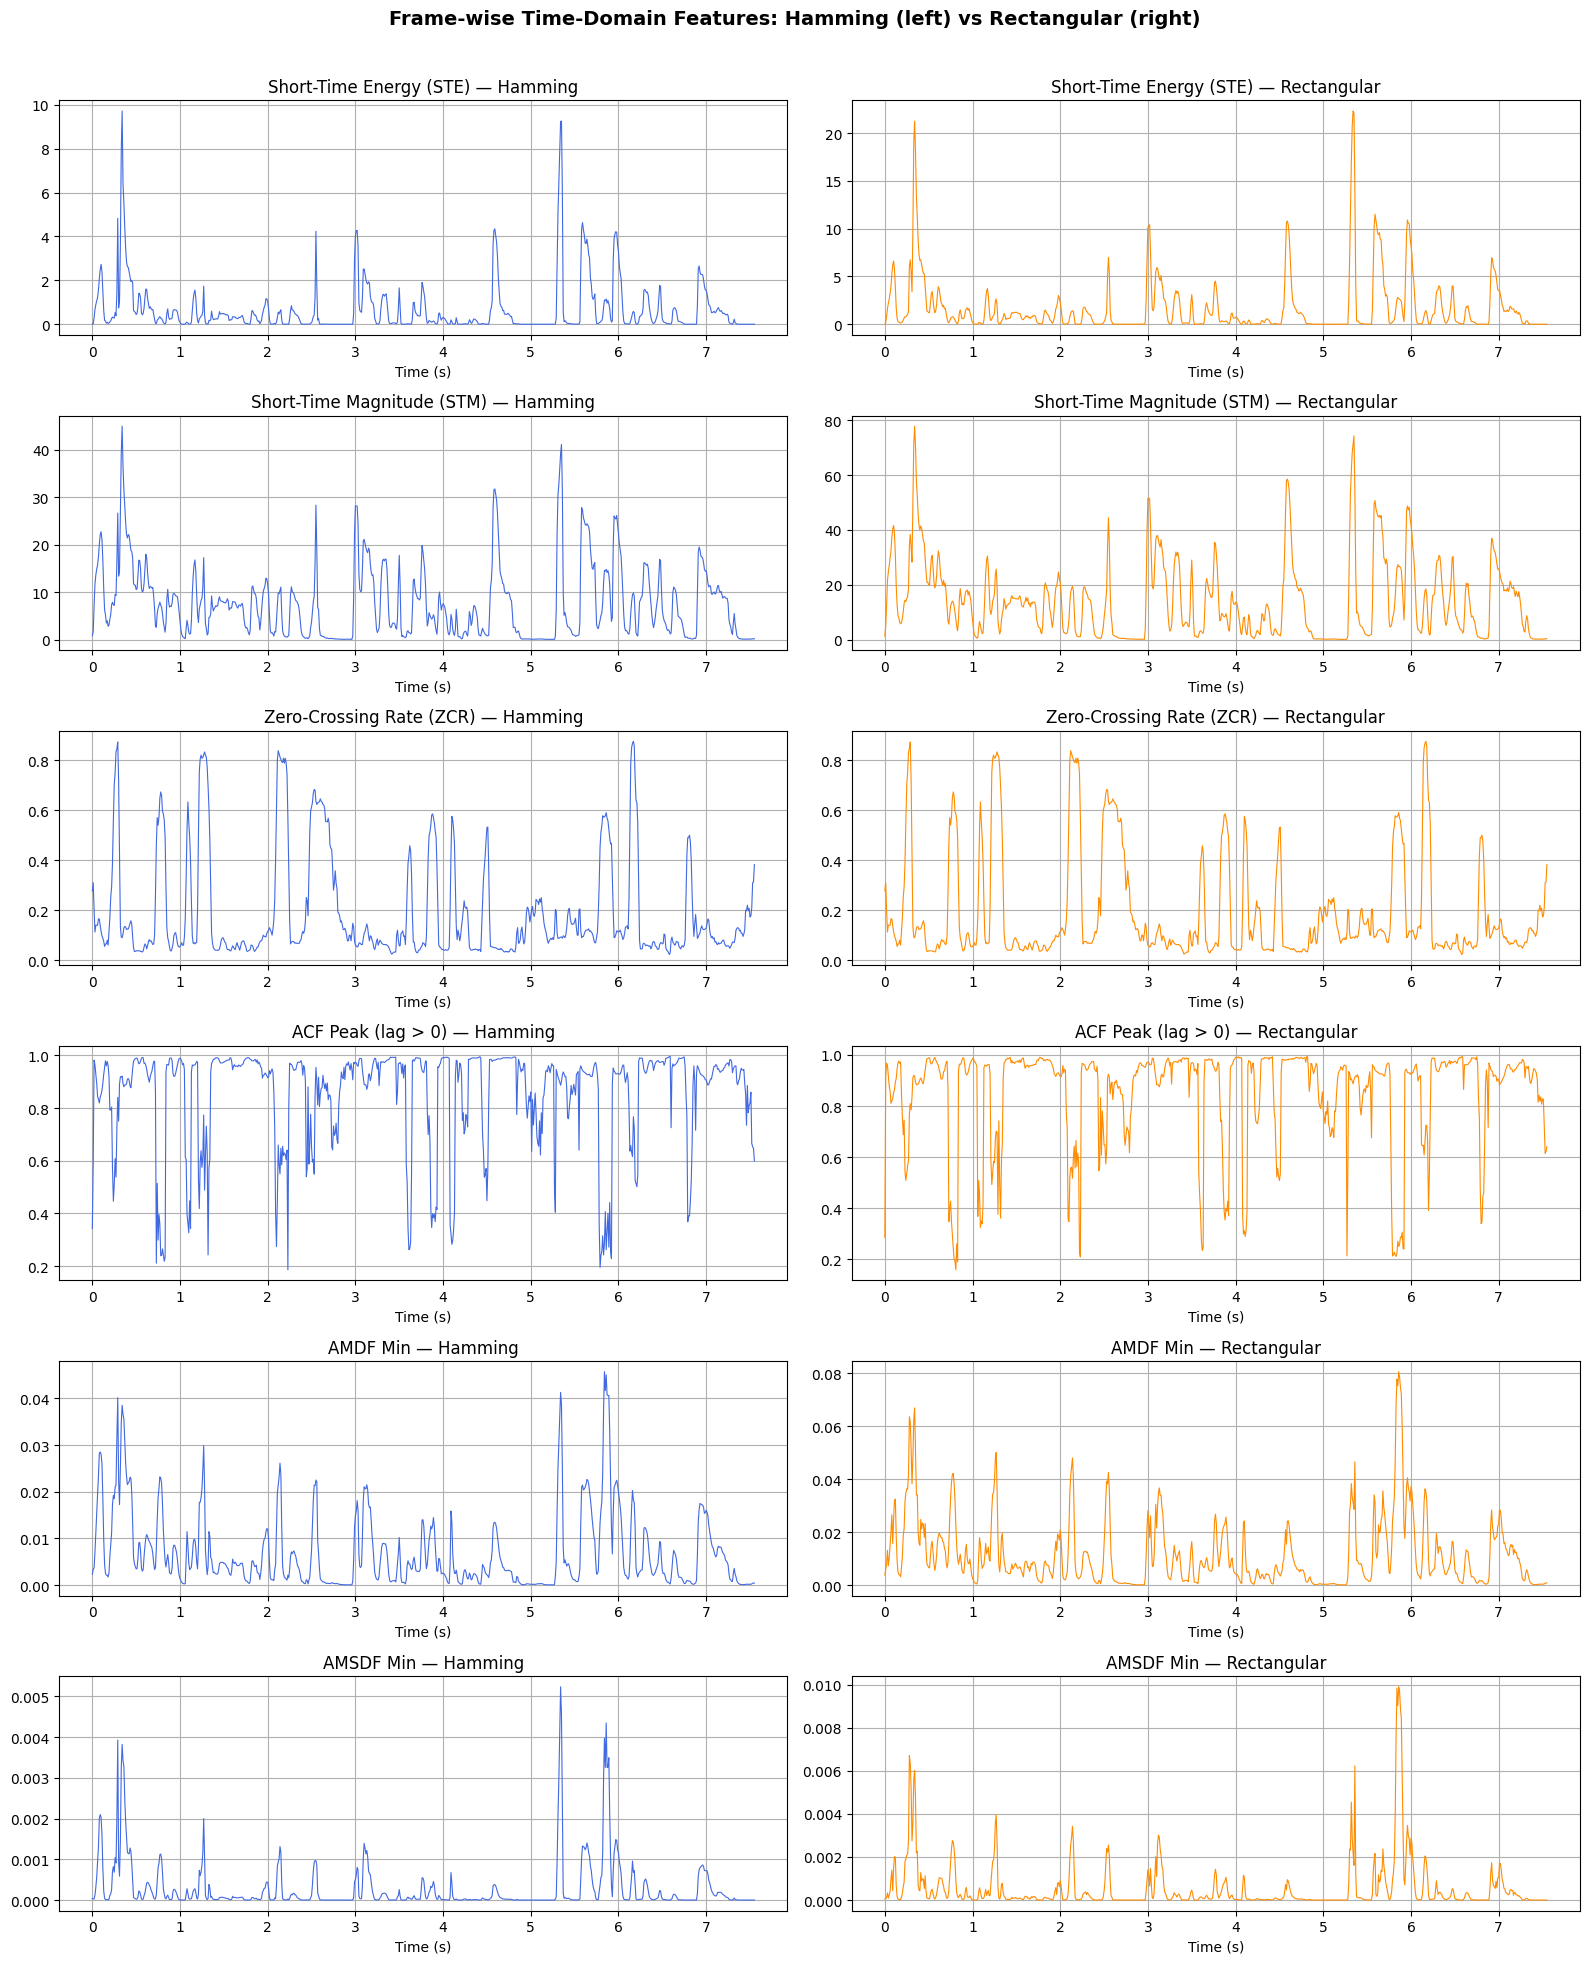

In [11]:
frame_times = np.arange(num_frames) * frame_shift_ms / 1000  # time in seconds

features = [
    ('Short-Time Energy (STE)',   ste_h,   ste_r),
    ('Short-Time Magnitude (STM)',stm_h,   stm_r),
    ('Zero-Crossing Rate (ZCR)',  zcr_h,   zcr_r),
    ('ACF Peak (lag > 0)',        acf_h,   acf_r),
    ('AMDF Min',                  amdf_h,  amdf_r),
    ('AMSDF Min',                 amsdf_h, amsdf_r),
]

fig, axes = plt.subplots(6, 2, figsize=(16, 20))
fig.suptitle('Frame-wise Time-Domain Features: Hamming (left) vs Rectangular (right)', fontsize=14, fontweight='bold')

for row, (name, feat_h, feat_r) in enumerate(features):
    axes[row, 0].plot(frame_times, feat_h, color='royalblue', linewidth=0.8)
    axes[row, 0].set_title(f'{name} — Hamming')
    axes[row, 0].set_xlabel('Time (s)')

    axes[row, 1].plot(frame_times, feat_r, color='darkorange', linewidth=0.8)
    axes[row, 1].set_title(f'{name} — Rectangular')
    axes[row, 1].set_xlabel('Time (s)')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### 1g) Analysis: Voiced vs Unvoiced Behaviour

We use a simple energy-based Voice Activity Detector (VAD) to label frames as voiced or unvoiced, then compare feature statistics.

In [12]:
# Simple energy-based VAD
ste_norm = ste_h / np.max(ste_h)
energy_threshold = 0.05  # tune if needed
voiced_mask   = ste_norm >= energy_threshold
unvoiced_mask = ~voiced_mask

print(f'Voiced frames   : {np.sum(voiced_mask)}')
print(f'Unvoiced frames : {np.sum(unvoiced_mask)}')

# Comparison table
print('\n--- Feature Comparison: Voiced vs Unvoiced (Hamming) ---')
for name, feat in [('STE', ste_h), ('STM', stm_h), ('ZCR', zcr_h),
                    ('ACF Peak', acf_h), ('AMDF Min', amdf_h), ('AMSDF Min', amsdf_h)]:
    v_mean = np.mean(feat[voiced_mask])   if np.any(voiced_mask)   else 0
    u_mean = np.mean(feat[unvoiced_mask]) if np.any(unvoiced_mask) else 0
    print(f'  {name:<10}  Voiced={v_mean:.4f}   Unvoiced={u_mean:.4f}')

Voiced frames   : 256
Unvoiced frames : 500

--- Feature Comparison: Voiced vs Unvoiced (Hamming) ---
  STE         Voiced=1.7318   Unvoiced=0.1118
  STM         Voiced=16.1391   Unvoiced=3.3600
  ZCR         Voiced=0.1416   Unvoiced=0.2187
  ACF Peak    Voiced=0.9128   Unvoiced=0.8219
  AMDF Min    Voiced=0.0141   Unvoiced=0.0035
  AMSDF Min   Voiced=0.0007   Unvoiced=0.0001


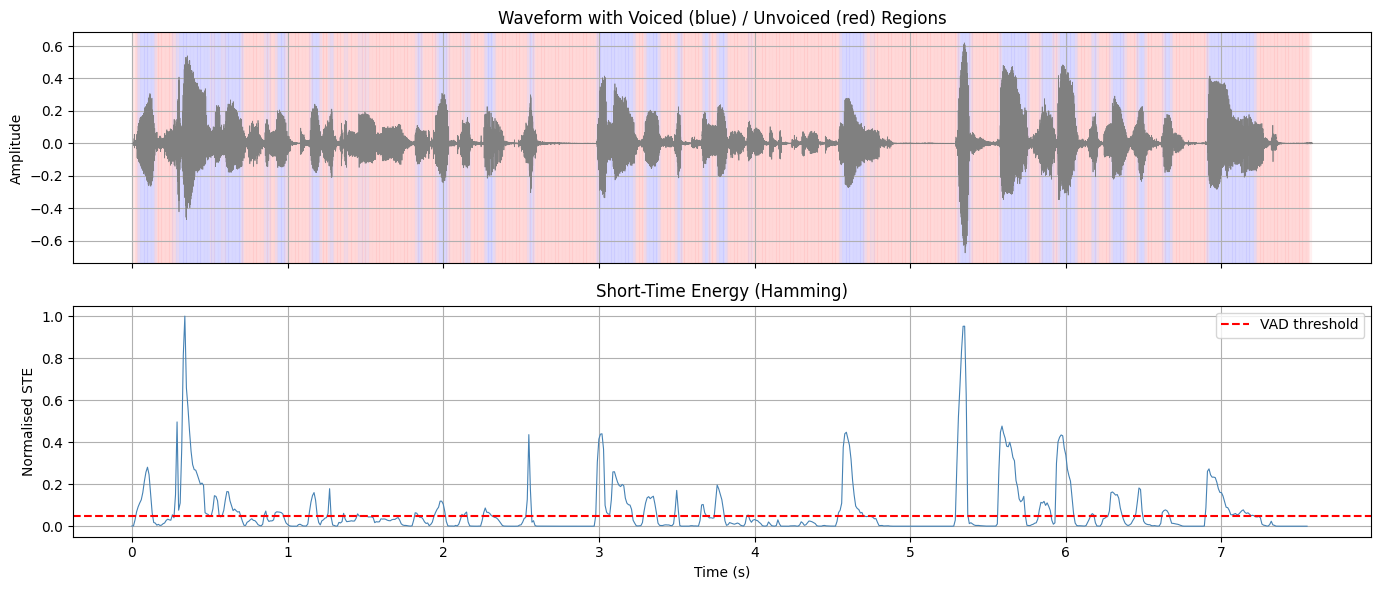

In [13]:
# Visualise voiced/unvoiced labels against waveform + STE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax1.plot(time_axis, signal, linewidth=0.5, color='gray')
ax1.set_ylabel('Amplitude')
ax1.set_title('Waveform with Voiced (blue) / Unvoiced (red) Regions')
for i, t in enumerate(frame_times):
    c = 'blue' if voiced_mask[i] else 'red'
    ax1.axvspan(t, t + frame_length_ms/1000, alpha=0.04, color=c)

ax2.plot(frame_times, ste_norm, color='steelblue', linewidth=0.8)
ax2.axhline(energy_threshold, color='red', linestyle='--', label='VAD threshold')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Normalised STE')
ax2.set_title('Short-Time Energy (Hamming)')
ax2.legend()

plt.tight_layout()
plt.show()

#### Observations — Feature Behaviour for Voiced vs Unvoiced Speech

| Feature | Voiced Speech | Unvoiced Speech | Inference |
|---------|--------------|----------------|-----------|
| **STE** | High — periodic vocal cord vibration generates larger amplitude oscillations | Low — turbulent noise has small amplitude | Good voiced/unvoiced discriminator |
| **STM** | High | Low | Similar to STE; robust to squaring non-linearities |
| **ZCR** | Low — slow, quasi-periodic oscillations cross zero infrequently | High — fricative noise crosses zero rapidly | Reliable V/UV classifier; unvoiced ZCR can be 3–5× higher |
| **ACF Peak** | High (close to 1) — strong periodicity gives a prominent peak at pitch lag | Low — aperiodic signals have no dominant lag | Core feature for pitch detection |
| **AMDF Min** | Low — self-similarity at pitch period makes differences small | High — no periodic self-similarity | Computationally cheap pitch detector |
| **AMSDF Min** | Low | High | Same as AMDF but more sensitive to large differences |

### 1h) Effect of Window Choice

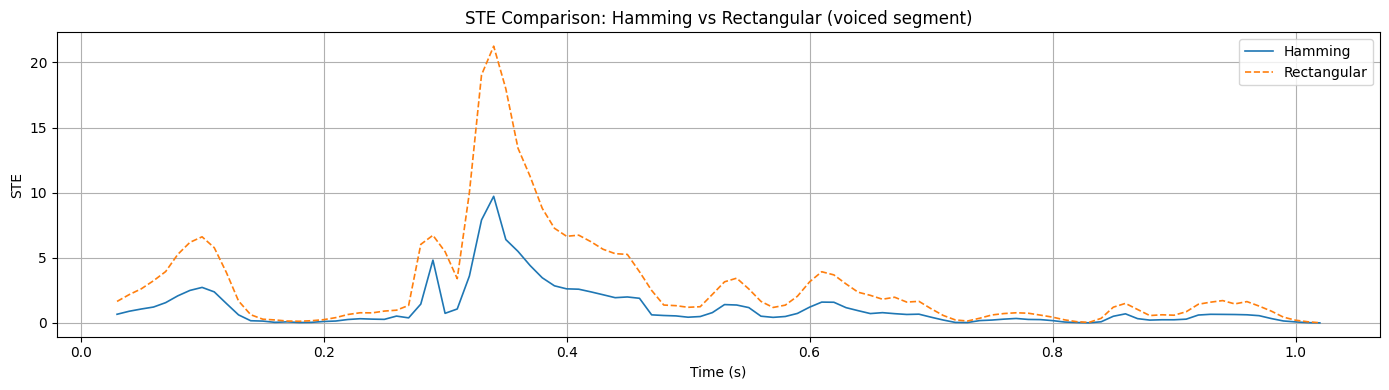

In [14]:
# Show side-by-side STE for one voiced segment
v_frames = np.where(voiced_mask)[0]
if len(v_frames) > 0:
    start_frame = v_frames[0]
    end_frame   = min(v_frames[0] + 100, num_frames)
    seg_times   = frame_times[start_frame:end_frame]

    plt.figure(figsize=(14, 4))
    plt.plot(seg_times, ste_h[start_frame:end_frame],   label='Hamming', linewidth=1.2)
    plt.plot(seg_times, ste_r[start_frame:end_frame],   label='Rectangular', linewidth=1.2, linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('STE')
    plt.title('STE Comparison: Hamming vs Rectangular (voiced segment)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No voiced frames detected — lower the VAD threshold.')

#### Window Effect Discussion

- **Hamming window** tapers to near-zero at frame edges, reducing spectral leakage and producing **smoother feature contours** with better discrimination between voiced and unvoiced regions.
- **Rectangular window** treats all samples equally. The abrupt edges cause **Gibbs-like ringing** and artificial discontinuities at frame boundaries, making feature curves slightly noisier and less smooth.
- For pitch-related features (ACF, AMDF, AMSDF), the Hamming window suppresses spurious peaks caused by edge effects, resulting in more reliable pitch period estimation.
- For ZCR and energy, the rectangular window may appear to give slightly higher values due to edge artifacts, but discrimination capability remains similar.
- **Conclusion:** Hamming window is preferred for speech analysis due to better spectral containment and smoother feature trajectories.

---
## Task 2 — Periodicity Analysis

### 2a) Identify Periodic Frames

Periodic (voiced) frames  : 731
Aperiodic (unvoiced) frames: 25


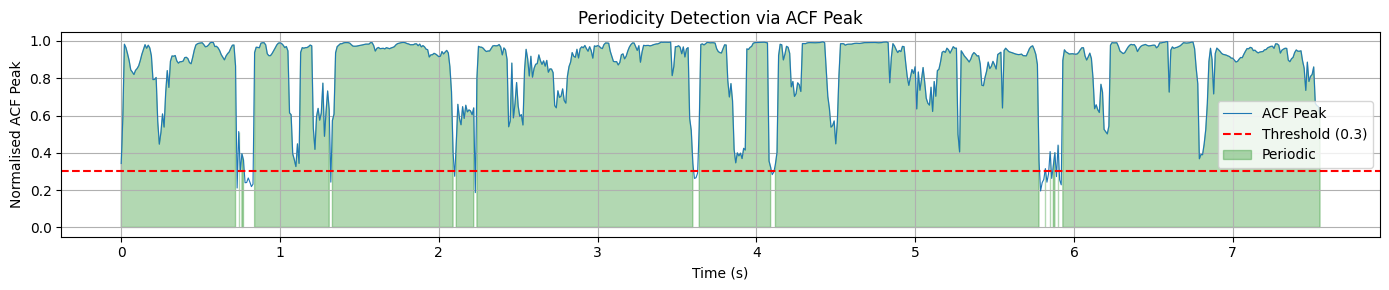

In [15]:
ACF_THRESHOLD = 0.3   # frames with ACF peak > this are considered periodic

periodic_mask = acf_h >= ACF_THRESHOLD
print(f'Periodic (voiced) frames  : {np.sum(periodic_mask)}')
print(f'Aperiodic (unvoiced) frames: {np.sum(~periodic_mask)}')

plt.figure(figsize=(14, 3))
plt.plot(frame_times, acf_h, linewidth=0.8, label='ACF Peak')
plt.axhline(ACF_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({ACF_THRESHOLD})')
plt.fill_between(frame_times, acf_h, where=periodic_mask, alpha=0.3, color='green', label='Periodic')
plt.xlabel('Time (s)')
plt.ylabel('Normalised ACF Peak')
plt.title('Periodicity Detection via ACF Peak')
plt.legend()
plt.tight_layout()
plt.show()

### 2b) Periodicity in ACF, AMDF, AMSDF — Single-Frame Illustration

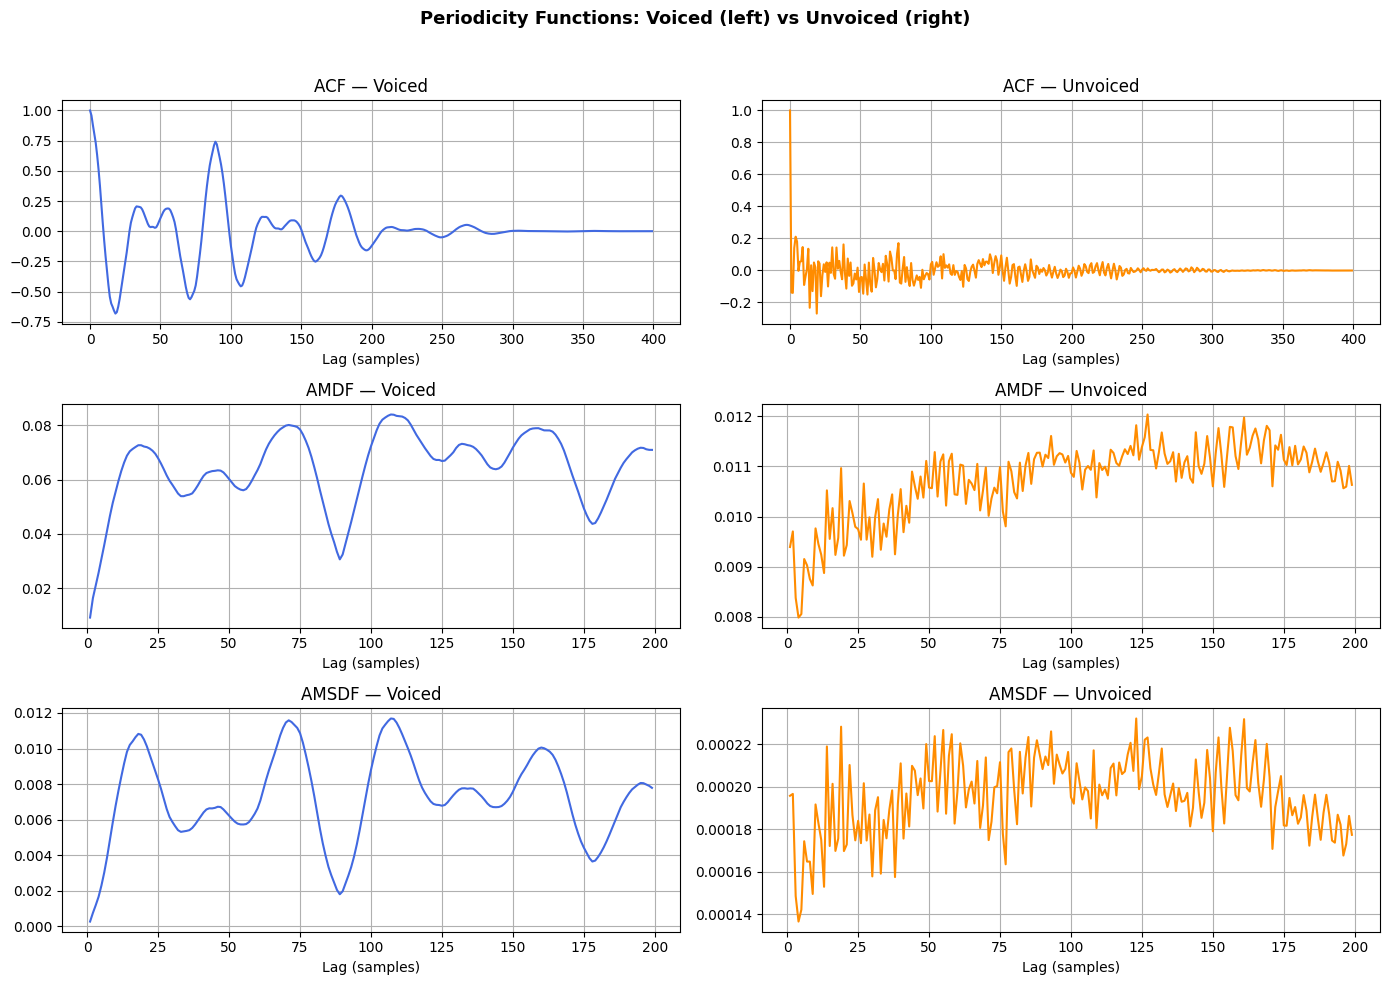

In [16]:
# Pick one clearly periodic frame and one clearly aperiodic frame
if np.any(periodic_mask) and np.any(~periodic_mask):
    voiced_idx   = np.where(periodic_mask)[0][len(np.where(periodic_mask)[0])//2]  # middle voiced
    unvoiced_idx = np.where(~periodic_mask)[0][0]

    frame_v = frames_hamming[voiced_idx]
    frame_u = frames_hamming[unvoiced_idx]

    N = frame_length
    lags = np.arange(0, N)

    def full_acf(frame):
        a = np.correlate(frame, frame, mode='full')
        a = a[len(frame)-1:]
        return a / a[0] if a[0] != 0 else a

    def full_amdf(frame):
        return np.array([np.mean(np.abs(frame[k:] - frame[:N-k])) for k in range(1, N//2)])

    def full_amsdf(frame):
        return np.array([np.mean((frame[k:] - frame[:N-k])**2) for k in range(1, N//2)])

    acf_v, acf_u   = full_acf(frame_v),   full_acf(frame_u)
    amdf_v, amdf_u = full_amdf(frame_v),  full_amdf(frame_u)
    amsdf_v, amsdf_u = full_amsdf(frame_v), full_amsdf(frame_u)

    lag_axis  = np.arange(len(acf_v))
    diff_axis = np.arange(1, N//2)

    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle('Periodicity Functions: Voiced (left) vs Unvoiced (right)', fontsize=13, fontweight='bold')

    axes[0,0].plot(lag_axis, acf_v, 'royalblue');  axes[0,0].set_title('ACF — Voiced')
    axes[0,1].plot(lag_axis, acf_u, 'darkorange'); axes[0,1].set_title('ACF — Unvoiced')
    axes[1,0].plot(diff_axis, amdf_v, 'royalblue');  axes[1,0].set_title('AMDF — Voiced')
    axes[1,1].plot(diff_axis, amdf_u, 'darkorange'); axes[1,1].set_title('AMDF — Unvoiced')
    axes[2,0].plot(diff_axis, amsdf_v, 'royalblue');  axes[2,0].set_title('AMSDF — Voiced')
    axes[2,1].plot(diff_axis, amsdf_u, 'darkorange'); axes[2,1].set_title('AMSDF — Unvoiced')

    for ax in axes.flat:
        ax.set_xlabel('Lag (samples)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print('Adjust thresholds to identify voiced/unvoiced frames.')

### 2c) Distinguishing Periodic vs Aperiodic Frames

| Measure | Periodic (Voiced) | Aperiodic (Unvoiced) |
|---------|-------------------|---------------------|
| **ACF** | Clear secondary peaks at multiples of pitch period T₀ | Rapidly decaying, noisy, no dominant peak |
| **AMDF** | Deep valley (minimum) at lag = T₀ | Roughly flat — no significant minimum |
| **AMSDF** | Sharp minimum at lag = T₀ | Flat and elevated throughout |

**Explanation:** In voiced speech the glottal source is quasi-periodic with period T₀ (pitch period). When the analysis window aligns at lag T₀, the signal is correlated with itself, giving ACF a peak and AMDF/AMSDF a minimum. Unvoiced speech is spectrally similar to white noise — no such self-similarity exists at any lag.

---
## Task 3 — Pitch Estimation

### 3a & 3b) Pitch Period and Frequency Estimation

In [17]:
def estimate_pitch_acf(frame, sr, f0_min=60, f0_max=400):
    """Estimate pitch period (samples) and frequency (Hz) using ACF."""
    N = len(frame)
    acf = np.correlate(frame, frame, mode='full')
    acf = acf[N-1:]       # non-negative lags
    if acf[0] != 0:
        acf = acf / acf[0]

    lag_min = int(sr / f0_max)   # shortest allowable pitch period
    lag_max = int(sr / f0_min)   # longest  allowable pitch period
    lag_max = min(lag_max, N-1)

    if lag_min >= lag_max:
        return None, None

    search = acf[lag_min:lag_max+1]
    pitch_lag = np.argmax(search) + lag_min
    pitch_freq = sr / pitch_lag if pitch_lag > 0 else 0
    return pitch_lag, pitch_freq

def estimate_pitch_amdf(frame, sr, f0_min=60, f0_max=400):
    """Estimate pitch using first minimum of AMDF."""
    N = len(frame)
    lag_min = int(sr / f0_max)
    lag_max = int(sr / f0_min)
    lag_max = min(lag_max, N//2 - 1)
    if lag_min >= lag_max:
        return None, None
    amdf = np.array([np.mean(np.abs(frame[k:] - frame[:N-k])) for k in range(lag_min, lag_max+1)])
    pitch_lag  = np.argmin(amdf) + lag_min
    pitch_freq = sr / pitch_lag if pitch_lag > 0 else 0
    return pitch_lag, pitch_freq

# Estimate pitch for all periodic frames
pitch_freq_acf   = np.zeros(num_frames)
pitch_freq_amdf  = np.zeros(num_frames)

for i in range(num_frames):
    if periodic_mask[i]:
        frame = frames_hamming[i]
        _, f_acf  = estimate_pitch_acf(frame, sr)
        _, f_amdf = estimate_pitch_amdf(frame, sr)
        pitch_freq_acf[i]  = f_acf  if f_acf  else 0
        pitch_freq_amdf[i] = f_amdf if f_amdf else 0

print('Pitch estimation complete.')
valid_acf  = pitch_freq_acf[pitch_freq_acf > 0]
valid_amdf = pitch_freq_amdf[pitch_freq_amdf > 0]
if len(valid_acf)  > 0: print(f'ACF  — Mean F0: {np.mean(valid_acf):.1f} Hz  |  Median: {np.median(valid_acf):.1f} Hz')
if len(valid_amdf) > 0: print(f'AMDF — Mean F0: {np.mean(valid_amdf):.1f} Hz  |  Median: {np.median(valid_amdf):.1f} Hz')

Pitch estimation complete.
ACF  — Mean F0: 216.9 Hz  |  Median: 202.5 Hz
AMDF — Mean F0: 228.0 Hz  |  Median: 213.3 Hz


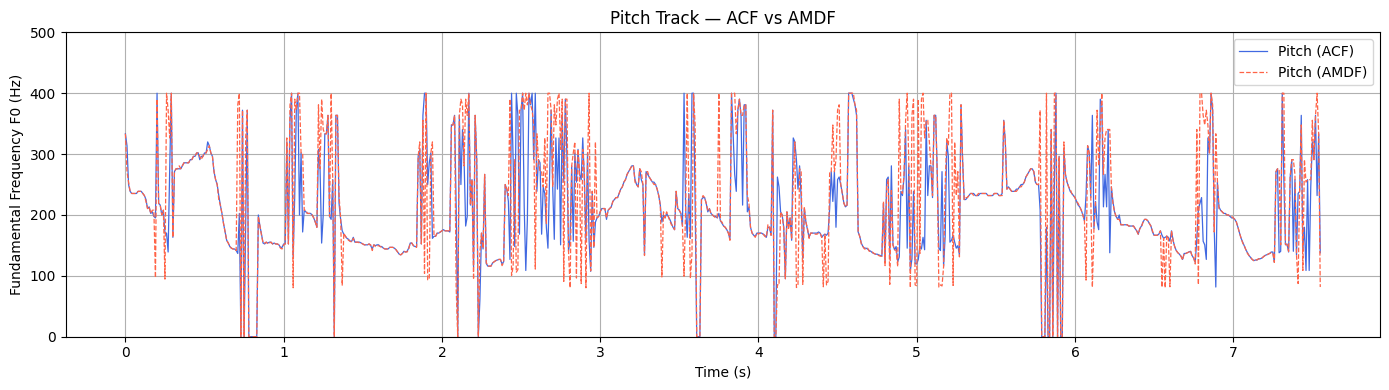

In [18]:
plt.figure(figsize=(14, 4))
plt.plot(frame_times, pitch_freq_acf,  label='Pitch (ACF)',  linewidth=0.9, color='royalblue')
plt.plot(frame_times, pitch_freq_amdf, label='Pitch (AMDF)', linewidth=0.9, color='tomato', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Fundamental Frequency F0 (Hz)')
plt.title('Pitch Track — ACF vs AMDF')
plt.ylim(0, 500)
plt.legend()
plt.tight_layout()
plt.show()

#### Interpretation

- Typical **male pitch:** 85–180 Hz. Typical **female pitch:** 165–255 Hz.
- Frames with estimated F0 in the physiologically plausible range (60–400 Hz) are reliable voiced frames.
- ACF and AMDF generally agree on the pitch contour; differences arise at frame transitions where one method may detect octave errors (e.g., picking a harmonic instead of the fundamental).

---
## Discussion

### a) Voiced vs Unvoiced Speech: Energy, ZCR, and Periodicity

Voiced speech is produced by quasi-periodic vocal cord vibrations exciting the vocal tract. This results in:
- **High STE/STM** due to concentrated energy in harmonics.
- **Low ZCR** because the waveform oscillates slowly at the pitch frequency (e.g., 100–300 zero-crossings per second vs 2000–5000 for unvoiced).
- **High periodicity** reflected as prominent ACF peaks and sharp AMDF/AMSDF minima at the pitch lag.

Unvoiced speech (fricatives, stops) is generated by turbulent airflow and shows:
- **Low STE/STM** — broadband noise has smaller amplitude.
- **High ZCR** — rapid random oscillations cross zero frequently.
- **No periodicity** — ACF decays immediately; AMDF/AMSDF remain flat.

### b) Periodicity-Based Features for Pitch Detection

ACF, AMDF, and AMSDF exploit the temporal self-similarity of voiced speech. A periodic signal with period T₀ produces:
- An ACF peak at lag T₀ (and its multiples).
- An AMDF/AMSDF minimum at lag T₀ — because the frame subtracted from itself shifted by exactly one period yields near-zero difference.

This makes the lag at which the peak/minimum occurs a direct measure of the pitch period: F0 = Fs / T₀.

### c) Reliability of Time-Domain Features for Pitch Detection

| Feature | Reliability | Notes |
|---------|-------------|-------|
| **STE/STM** | Low for pitch | Good for V/UV detection, not for pitch period |
| **ZCR** | Low for pitch | Useful for V/UV, but pitch from ZCR is unreliable |
| **ACF** | High | Gold standard for time-domain pitch; susceptible to octave errors |
| **AMDF** | High | Computationally cheaper than ACF; sometimes preferred in real-time systems |
| **AMSDF** | High | More sensitive than AMDF; can be noisier in low SNR conditions |

**Conclusion:** ACF is the most widely used and reliable time-domain pitch estimator. AMDF is a computationally efficient alternative. Combined use of multiple features (e.g., ACF for detection + AMDF for confirmation) improves robustness. All time-domain methods are sensitive to noise; for noisy conditions, frequency-domain methods (CEPSTRUM, HPS) or deep learning approaches are preferred.